<img src="images/oil.png" alt="Local Image" style="width: 100%;">

# Analyzing the Impact of OPEC Crude Oil Production Quotas on Global Markets

#### Will Rodman | Data Science | Tulane University 
#### Project Link: https://willcrodman.github.io

## Project Outline

This project will analyze the impact of **OPEC** (Organization of the Petroleum Exporting Countries) crude oil production quotas on the oil markets of both OPEC and **OECD** (Organization for Economic Co-operation and Development) countries from 1960 to 2022. Including providing political context of OPEC and OECD, exploring their respective roles and significance in the global oil trade. The data source for this project is from the official OPEC website, which includes data such as crude oil production, demand, spot prices, refinery throughput, and capacity by country.

Founded in 1960, OPEC comprises a group of petroleum-exporting nations. OPEC was created with the primary aim of asserting collective control over their oil resources and global oil trade. OPEC's founding members included Iran, Iraq, Kuwait, Saudi Arabia, and Venezuela. Over the years, the organization has expanded to include several other member nations, totaling 13.

This project places a unique focus on OPEC member nations due to their global importance as petroleum exporters. Alongside OECD countries, who are reliant on oil imports to meet their energy needs, and have historically been affected by changes in OPEC production quotas and embargoes.



#### Data Source: https://asb.opec.org/data/ASB_Data.php


In [1]:
# Installing library requirements.
!pip install pandas numpy scipy matplotlib sklearn --quiet

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [2]:
# Import library requirements.
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import re
from pandas.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler

warnings.simplefilter(action='ignore', category=FutureWarning)

<img src="images/opec.png" alt="Local Image" style="width: 50%;">

## OPEC and OCED Countries

While OPEC consists of major oil-producing nations such as Saudi Arabia, Iran, Iraq, and Venezuela, among others. OECD comprises economically advanced nations, primarily in Europe and North America, which heavily rely on oil imports to fulfill their energy requirements. Currently there are 38 member countries in OECD including the United States and United Kingdom. 

In [3]:
# List of OPEC countries in 2023. 
opec_countries = pd.read_csv('data/countries/opec.csv', header=None, squeeze=True)
opec_countries.head(13)

0                  Algeria
1                   Angola
2        Equatorial Guinea
3                    Gabon
4                 I.R.Iran
5                     Iraq
6                   Kuwait
7                    Libya
8                  Nigeria
9                    Congo
10            Saudi Arabia
11    United Arab Emirates
12               Venezuela
Name: 0, dtype: object

In [4]:
# List of OECD countries in 2023. 
oecd_countries = pd.read_csv('data/countries/oecd.csv', header=None, squeeze=True)
oecd_countries.head()

0    Australia
1      Austria
2      Belgium
3       Canada
4        Chile
Name: 0, dtype: object

## Crude Oil Production and Demand

### Extract, Transform, and Load (ETL) Data

This imports crude oil production and demand for countries world wide (including all OPEC members) from 1960 to 2020. **Crude Oil** refers to the fossil fuel that exits in Earths geological formations.  They will be stored in the project as Pandas DataFrames, along with a third DataFrame that describes countries domestic crude oil demand deficits per year. 

$\text{Deficit}_{\text{year}} = \text{Production}_{\text{year}} - \text{Consumption}_{\text{year}}$





In [5]:
# Importing oil production dataset.
oil_production_df = pd.read_csv("data/opec_upstream/world_oil_production.csv", index_col="Index")
oil_production_df.replace('na', np.nan, inplace=True)
oil_production_df = oil_production_df.astype(float)

# Replacing incorrectly labeled countries. 
replace = {'IR Iran': 'I.R.Iran', 'Saudi Arabia1': 'Saudi Arabia', 'Kuwait1': 'Kuwait', 'Syrian Arab Rep.': 'Syria', 'Uzbekistan`': 'Uzbekistan'}
oil_production_df = oil_production_df.rename(index=replace)

# Importing oil demand dataset. 
oil_demand_df = pd.read_csv("data/opec_downstream/world_oil_demand.csv", index_col="Index")
oil_demand_df.replace('na', np.nan, inplace=True)
oil_demand_df = oil_demand_df.astype(float)

# Merging oil production and oil demand datasets; One-to-one matching needed to compute oil deficit. 
oil_deficit_df = oil_demand_df.merge(oil_production_df, left_index=True, right_index=True, how='inner')

# Iterating over years of oil production and oil demand to compute oil deficit. 
for year in range(1960, 2023):
    year_x, year_y = f"{year}_x", f"{year}_y"
    oil_deficit_df[year] = oil_deficit_df[year_x] - oil_deficit_df[year_y]
    oil_deficit_df = oil_deficit_df.drop(columns=[year_x, year_y])
    
# Transposing DataFrames to set years as index.  
oil_production_df = oil_production_df.transpose()
oil_demand_df = oil_demand_df.transpose()
oil_deficit_df = oil_deficit_df.transpose()

# Converting year index to datetime object. 
oil_production_df.index = pd.to_datetime(oil_production_df.index, format='%Y')
oil_demand_df.index = pd.to_datetime(oil_demand_df.index, format='%Y')
oil_deficit_df.index = pd.to_datetime(oil_deficit_df.index, format='%Y')

# Display DataFrame
oil_deficit_df.head() 


Index,Canada,Chile,Mexico,United States,United Kingdom,Australia,China,India,Indonesia,Malaysia,...,Egypt,Equatorial Guinea,Gabon,Libya,Nigeria,Russia,Azerbaijan,Kazakhstan,OPEC,OECD
1960-01-01,290.164,24.395,-181.090,3189.7,918.239,269.000,105.50,143.806,-309.6,9.0,...,37.684,0.0,-12.4,4.0,-1.4,-1010.1,NaN,-4.1,-7773.752195,7966.45244
1961-01-01,213.230,23.284,-181.544,3213.1,969.721,287.000,100.85,153.615,-313.3,16.0,...,28.730,0.0,-11.9,-14.2,-27.0,-1214.3,NaN,-5.8,-8407.232041,8562.18744
1962-01-01,194.771,20.082,-181.161,3522.0,1063.617,297.000,96.55,138.397,-328.4,22.0,...,13.908,0.0,-13.4,-176.3,-50.5,-1398.8,NaN,-7.4,-9527.366548,9691.92063
1963-01-01,213.598,19.499,-154.292,3947.3,1155.410,336.000,120.15,143.370,-315.0,29.0,...,-1.710,0.0,-13.7,-435.8,-54.5,-1488.7,NaN,-7.2,-10522.296582,11105.58335
1964-01-01,234.151,21.190,-120.369,4106.7,1276.202,349.163,138.35,131.591,-318.6,36.0,...,-14.546,0.0,-17.0,-855.4,-96.2,-1671.7,NaN,1.7,-11910.261359,12455.20195


Because our two datasets do not have a perfect one-to-one matching, deficits cannot be computed for every country. This mean exploratory data analysis will be for all OPEC member countries and a limited number of OECD member countries. In addition here are the missing years for each country.

In [6]:
print('Countries in oil production DataFrame:', len(oil_production_df.columns))
print('Countries in oil demand DataFrame:', len(oil_demand_df.columns))
print('Countries in oil deficit DataFrame:', len(oil_deficit_df.columns))
oil_deficit_df.isna().sum()

Countries in oil production DataFrame: 48
Countries in oil demand DataFrame: 61
Countries in oil deficit DataFrame: 37


Index
Canada                   0
Chile                    0
Mexico                   0
United States            0
United Kingdom           0
Australia                0
China                    0
India                    0
Indonesia                0
Malaysia                 0
Thailand                 0
Vietnam                  0
Argentina                0
Brazil                   0
Colombia                 0
Ecuador                  0
Venezuela                0
I.R.Iran                 0
Iraq                     0
Kuwait                   0
Qatar                    0
Saudi Arabia             0
Syria                    0
United Arab Emirates     0
Algeria                  0
Angola                   0
Congo                    0
Egypt                    0
Equatorial Guinea        0
Gabon                    0
Libya                    0
Nigeria                  0
Russia                   0
Azerbaijan              30
Kazakhstan               0
OPEC                     0
OECD                  

### Exploratory Data Analysis (EDA)

This analysis visualized production demand over time using a line plot and box plot, visualization are categorized by: 
1. The top five oil producers in 2023. 
2. OPEC member countries. 
3. OECD member countries with accessible data. 

#### Box Plot Distribution
<img src="images/box.png" alt="Local Image" style="width: 25%;">


In [7]:
# Function graphs oil production, oil demand and oil deficit for a given list of countries. 
def line_plot_production(cols, title=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

    oil_production_df[cols].plot(kind='line', legend=False, ax=ax1)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Crude Oil (1000 barrels/day)')
    ax1.set_title('Domestic Production')

    oil_demand_df[cols].plot(kind='line', legend=False, ax=ax2)
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Crude Oil (1000 barrels/day)')
    ax2.set_title('Domestic Demand')

    oil_deficit_df[cols].plot(kind='line', legend=False, ax=ax3)
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Crude Oil (1000 barrels/day)')
    ax3.set_title('Domestic Deficit')
    ax3.axhline(y=0, color='black', linestyle='--')

    lines, labels = ax1.get_legend_handles_labels()
    fig.legend(lines, labels, loc='center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    fig.suptitle(title, fontsize=20, y=1.02)
    plt.tight_layout()
    
# Function plots the distributions of oil production, oil demand and oil deficit for a given list of countries. 
def box_plot_production(cols, title=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

    # Generating x-axis labels. 
    x_labels = list(oil_production_df.index.year)
    x_labels = [label if i % 5 == 0 else '' for i, label in enumerate(x_labels)]
    
    oil_production_df[cols].transpose().boxplot(ax=ax1, showfliers=False)
    ax1.set_title('Domestic Production')
    ax1.set_ylabel('Crude Oil (1000 barrels/day)')
    ax1.set_xlabel('Year')
    ax1.grid(False, axis='x')
    ax1.set_xticklabels(x_labels)
    ax1.set_ylim(0, 5000)

    oil_demand_df[cols].transpose().boxplot(ax=ax2, showfliers=False)
    ax2.set_title('Domestic Demand')
    ax2.set_ylabel('Crude Oil (1000 barrels/day)')
    ax2.set_xlabel('Year')
    ax2.grid(False, axis='x')
    ax2.set_xticklabels(x_labels)
    ax2.set_ylim(0, 5000)

    oil_deficit_df[cols].transpose().boxplot(ax=ax3, showfliers=False)  
    ax3.set_title('Domestic Deficit')
    ax3.set_ylabel('Crude Oil (1000 barrels/day)')
    ax3.set_xlabel('Year')
    ax3.axhline(y=0, color='red', linestyle='--')
    ax3.grid(False, axis='x')
    ax3.set_xticklabels(x_labels)

    fig.suptitle(title, fontsize=20, y=1.02)
    plt.tight_layout()

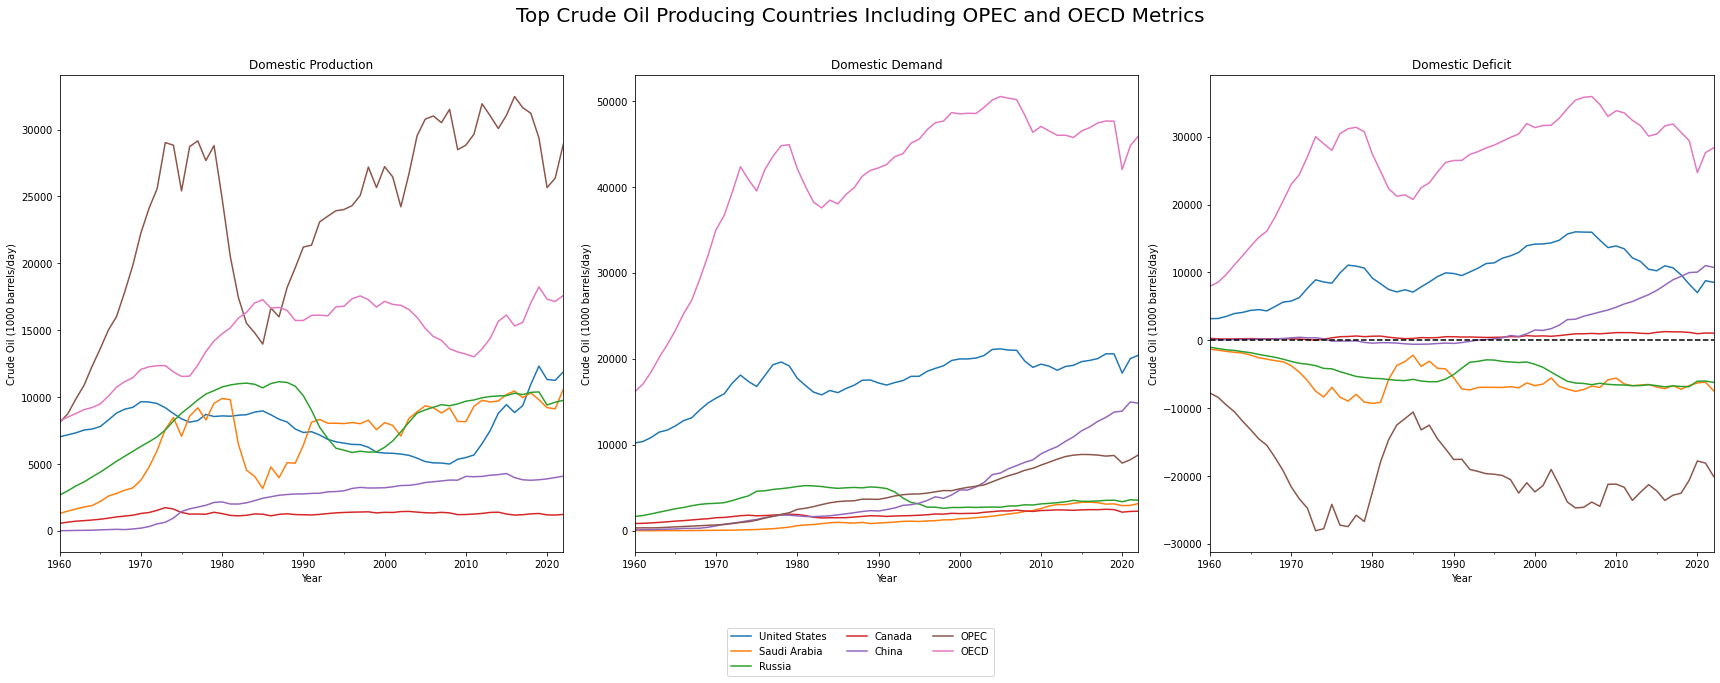

In [8]:
top_oil_producing_countries = ["United States", "Saudi Arabia", "Russia", "Canada", "China", "OPEC", "OECD"]
line_plot_production(top_oil_producing_countries, title="Top Crude Oil Producing Countries Including OPEC and OECD Metrics")

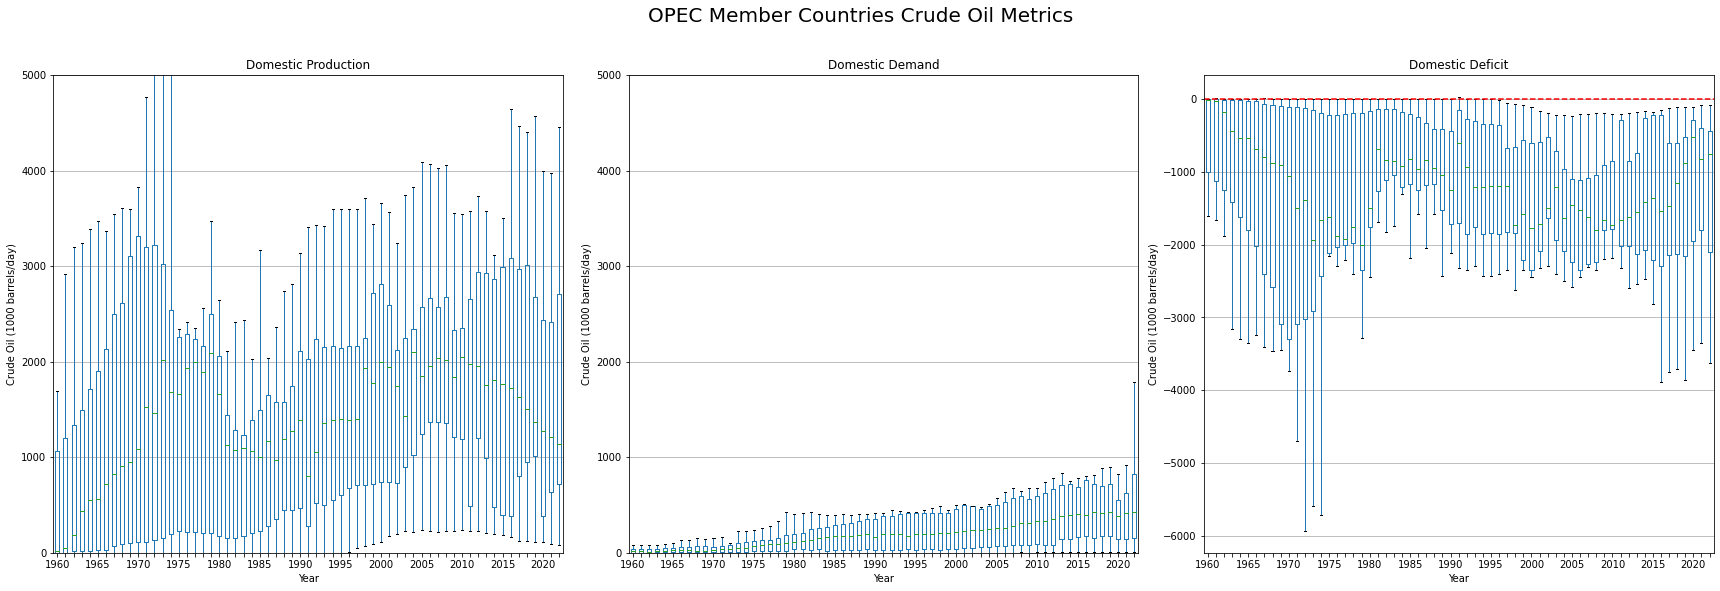

In [9]:
box_plot_production(opec_countries, title="OPEC Member Countries Crude Oil Metrics")

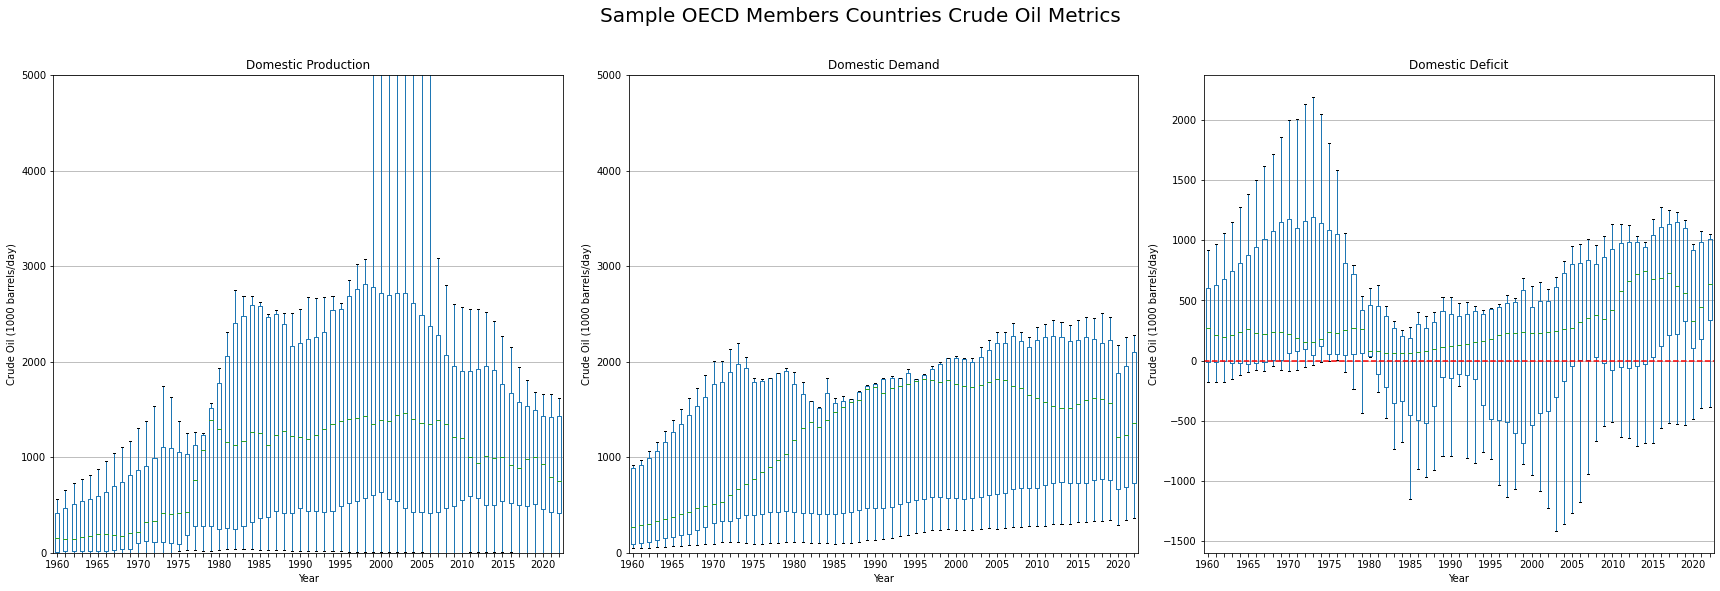

In [10]:
# Collecting OECD countries with accessible data. 
oecd_sample_countries = oecd_countries[oecd_countries.isin(oil_deficit_df.columns)]
box_plot_production(oecd_sample_countries, "Sample OECD Members Countries Crude Oil Metrics")

The visualization show how OPEC countries have a negative crude oil deficit, while the median sample of OECD have a positive crude oil deficit. It is also show how large economies United States (OECD member) Canada (OECD member), Saudi Arabia (OPEC member) and Russia (OEPC+ member) can influence the distributions. 

## Oil Refinery Load and Capacity 

### Extract, Transform, and Load (ETL) Data

This imports crude oil refinery utilization and capacities for countries world wide (including all OPEC members) from 1980 to 2022. A **Oil Refinery** processes crude oil into various refined products, including gasoline, diesel, and petrochemicals. They will be stored in the project as Pandas DataFrames, along with a third DataFrame that describes countries utilization rates of oil refineries per year. 

$\text{Utilization}_{\text{year}} = \left(1 - \frac{ \text{Refinery Capacity}_{\text{year}} - \text{Refinery Throughput}_{\text{year}}}{\text{Refinery Capacity}_{\text{year}}}\right) \times 100$

$0 <= \text{Utilization}_{\text{year}}$


In [11]:
# Importing oil production dataset.
refinery_capacity_df = pd.read_csv("data/opec_downstream/world_refinery_capacity.csv", index_col="Index")
refinery_capacity_df.replace('na', np.nan, inplace=True)
refinery_capacity_df.replace('n.a.', np.nan, inplace=True)
refinery_capacity_df = refinery_capacity_df.astype(float)

# Replacing incorrectly labeled countries. 
replace = {'United States2': 'United States',
        'South Korea2': 'South Korea',
        'Venezuela3': 'Venezuela',
        'I.R.Iran2': 'I.R.Iran',
        'Qatar2': 'Qatar',
        'Saudi Arabia2': 'Saudi Arabia',
        'United Arab Emirates2': 'United Arab Emirates',
        'Algeria2': 'Algeria'
        }
refinery_capacity_df = refinery_capacity_df.rename(index=replace)

# Importing oil demand dataset. 
refinery_throughput_df = pd.read_csv("data/opec_downstream/world_refinery_throughput.csv", index_col="Index")
refinery_throughput_df.replace('na', np.nan, inplace=True)
refinery_throughput_df.replace('n.a.', np.nan, inplace=True)
refinery_throughput_df = refinery_throughput_df.astype(float)

# Merging oil production and oil demand datasets; One-to-one matching needed to compute oil deficit. 
refinery_utilization_df = refinery_capacity_df.merge(refinery_throughput_df, left_index=True, right_index=True, how='inner')

# Iterating over years of oil production and oil demand to compute oil deficit. 
for year in range(1980, 2023):
    year_x, year_y = f"{year}_x", f"{year}_y"
    refinery_utilization_df[year] = (1 - (refinery_utilization_df[year_x] - refinery_utilization_df[year_y]) / refinery_utilization_df[year_x]) * 100
    refinery_utilization_df = refinery_utilization_df.drop(columns=[year_x, year_y])
    
# Fix rates for countries where throughput do not align perfectly. 
refinery_utilization_df = refinery_utilization_df.clip(upper=100)

# Transposing DataFrames to set years as index.  
refinery_capacity_df = refinery_capacity_df.transpose()
refinery_throughput_df = refinery_throughput_df.transpose()
refinery_utilization_df = refinery_utilization_df.transpose()

# Converting year index to datetime object. 
refinery_capacity_df.index = pd.to_datetime(refinery_capacity_df.index, format='%Y')
refinery_throughput_df.index = pd.to_datetime(refinery_throughput_df.index, format='%Y')
refinery_utilization_df.index = pd.to_datetime(refinery_utilization_df.index, format='%Y')

# Display. 
refinery_utilization_df.head()

Index,Algeria,Angola,Argentina,Australia,Azerbaijan,Belarus,Belgium,Brazil,Bulgaria,Canada,...,Spain,Thailand,Turkey,Turkmenistan,Ukraine,United Arab Emirates,United Kingdom,United States,Venezuela,Vietnam
1980-01-01,47.962649,80.385852,70.321637,78.699862,66.333333,97.564103,63.301887,77.889447,85.198556,91.280264,...,70.545977,86.440678,71.584699,66.923077,87.113857,80.000000,62.165264,78.109560,67.326869,NaN
1981-01-01,65.152801,77.881620,70.614035,73.655172,55.555556,98.205128,55.471698,75.251076,87.364621,84.846425,...,65.963432,89.265537,74.863388,66.923077,84.201236,41.481481,57.466243,74.740078,63.682003,NaN
1982-01-01,87.436333,65.420561,68.128655,75.310345,55.555556,98.333333,68.870523,72.944483,89.169675,74.736597,...,62.859145,88.700565,72.103004,59.754434,84.819064,61.481481,59.754494,74.833926,69.128575,NaN
1983-01-01,80.220713,80.996885,66.174298,69.655172,55.694444,98.589744,63.911846,70.522648,90.974729,79.696492,...,63.837375,92.090395,70.171674,59.754434,81.515855,61.111111,66.963403,73.073110,69.128575,NaN
1984-01-01,87.224109,87.227414,63.958641,70.124481,55.555556,98.461538,76.441516,74.912892,92.779783,78.809417,...,63.483965,89.265537,80.042918,59.754434,78.267595,78.888889,72.120896,77.624521,66.706329,NaN


Because our second datasets is larger then out first dataset, we do not have perfect one-to-one matching for our third dataset. In addition here are the missing years for each country.

In [12]:
print('Countries in oil refinery throughput DataFrame:', len(refinery_throughput_df.columns))
print('Countries in oil refinery capacity:', len(refinery_capacity_df.columns))
print('Countries in oil refinery utilization:', len(refinery_utilization_df.columns))
refinery_utilization_df.isna().sum()

Countries in oil refinery throughput DataFrame: 76
Countries in oil refinery capacity: 56
Countries in oil refinery utilization: 56


Index
Algeria                  0
Angola                   0
Argentina                0
Australia                0
Azerbaijan               0
Belarus                  0
Belgium                  0
Brazil                   0
Bulgaria                 0
Canada                   0
Chile                    0
China                    0
Colombia                 0
Congo                    2
Croatia                  0
Ecuador                  0
Egypt                    0
France                   0
Gabon                    0
Germany                  0
I.R.Iran                 0
India                    0
Indonesia                0
Iraq                     0
Italy                    0
Japan                    0
Kazakhstan               0
Kuwait                   0
Libya                    0
Malaysia                 0
Mexico                   0
Netherlands              0
New Zealand              0
Nigeria                  0
OECD                     0
OPEC                     0
Pakistan              

In [13]:
# Function plots refinery data.
def box_plot_refinery(cols, title=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

    # Generating x-axis labels. 
    x_labels = list(refinery_utilization_df.index.year)
    x_labels = [label if i % 5 == 0 else '' for i, label in enumerate(x_labels)]
    
    refinery_throughput_df[cols].transpose().boxplot(ax=ax1, showfliers=False)
    ax1.set_title('Total Throughput')
    ax1.set_ylabel('Crude Oil (1000 barrels/day)')
    ax1.set_xlabel('Year')

    ax1.grid(False, axis='x')
    ax1.set_xticklabels(x_labels)
    ax1.set_ylim(0, 4000)

    refinery_capacity_df[cols].transpose().boxplot(ax=ax2, showfliers=False)
    ax2.set_title('Total Capacity')
    ax2.set_ylabel('Crude Oil (1000 barrels/day)')
    ax2.set_xlabel('Year')
    ax2.grid(False, axis='x')
    ax2.set_xticklabels(x_labels)
    ax2.set_ylim(0, 4000)

    refinery_utilization_df[cols].transpose().boxplot(ax=ax3, showfliers=False)  
    ax3.set_title('Utilization')
    ax3.set_ylabel('Rate (%)')
    ax3.set_xlabel('Year')
    ax3.grid(False, axis='x')
    ax3.set_xticklabels(x_labels)
    ax3.set_ylim(0, 100)


    fig.suptitle(title, fontsize=20, y=1.02)
    plt.tight_layout()

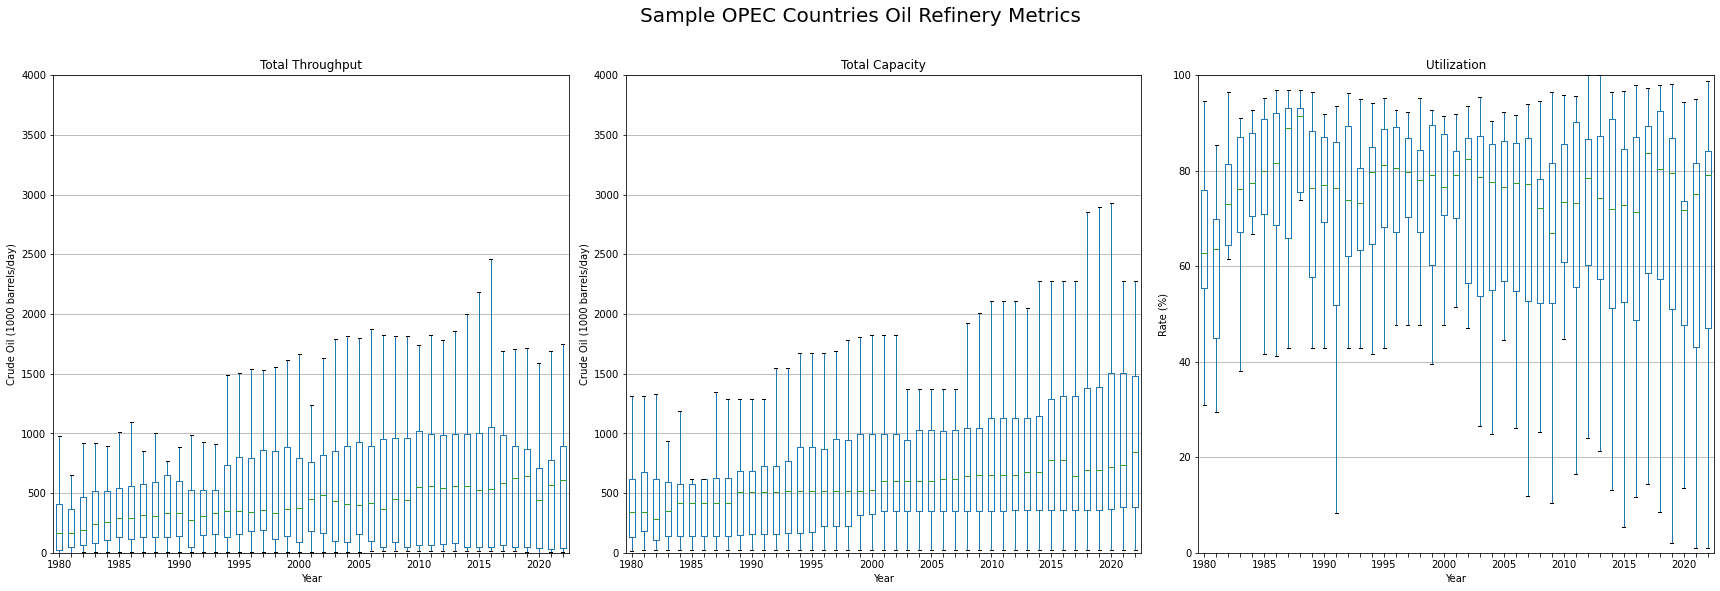

In [14]:
opec_sample_countries = opec_countries[opec_countries.isin(refinery_utilization_df.columns)]
box_plot_refinery(opec_sample_countries, title="Sample OPEC Countries Oil Refinery Metrics")

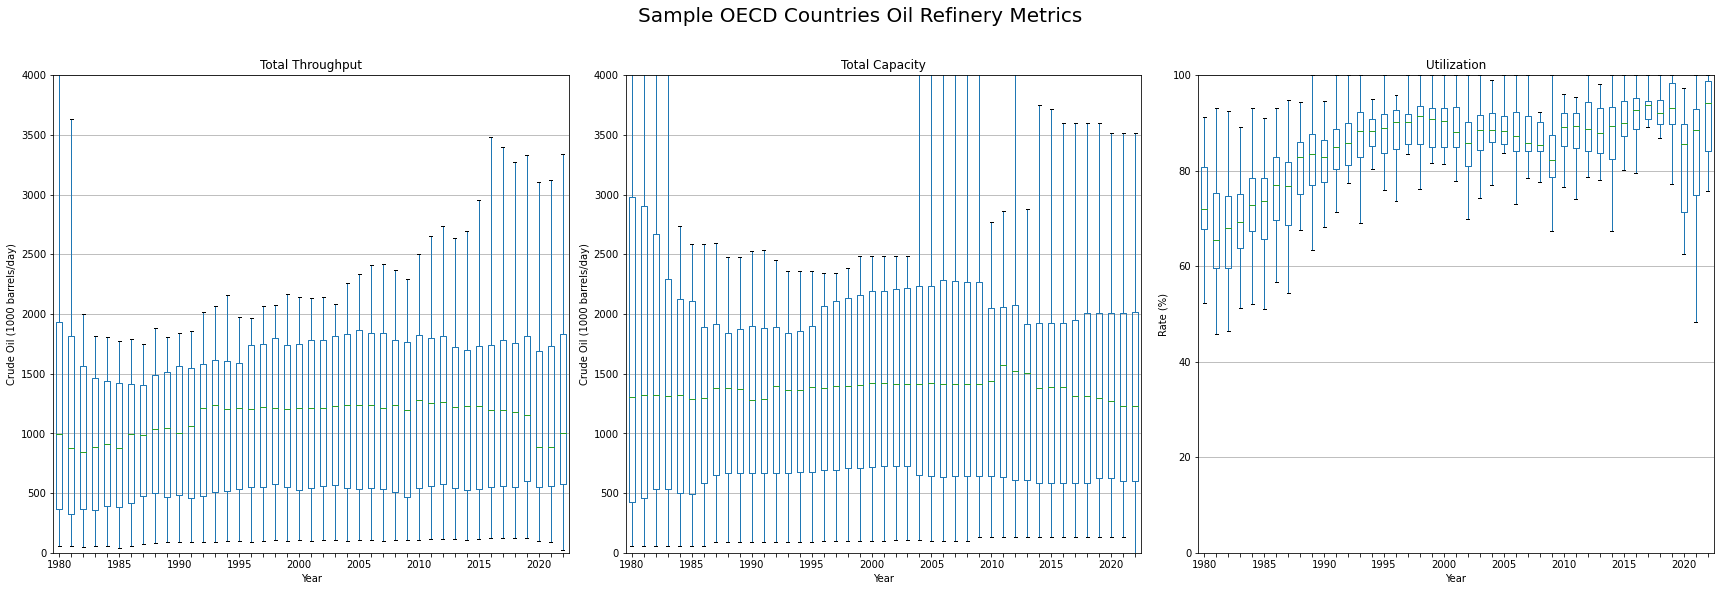

In [15]:
oecd_sample_countries = oecd_countries[oecd_countries.isin(refinery_utilization_df.columns)]
box_plot_refinery(oecd_sample_countries, title="Sample OECD Countries Oil Refinery Metrics")

OPEC Countries have more variance is their utilization of oil refineries then OECD countries. A factor of this could be the fact that OPEC sets production quotas for member countries, forcing members to not produce and use oil refineries at the most optimal domestic rate.   

## Crude Oil Spot Prices

### Extract, Transform, and Load (ETL) Data

This imports crude oil spot prices for countries world wide (including all OPEC members) from 1983 to 2022. The **Spot Price** is the current market equilibrium of a future contract; this is used to determine the current price a future contracts, which is how oil is traded. 

In [16]:
# Importing oil spot price dataset. 
oil_spot_prices_df = pd.read_csv("data/opec_prices/oil_spot_prices.csv", index_col="Index")
oil_spot_prices_df.replace('na', np.nan, inplace=True)
oil_spot_prices_df = oil_spot_prices_df.astype(float)

# Creating 2D index for countries with multiple oil benchmarks.  
oil_spot_prices_df.index = oil_spot_prices_df.index.str.split(' - ', expand=True)

# Replacing incorrectly labeled countries. 
oil_spot_prices_df = oil_spot_prices_df.rename(index={'IR Iran': 'I.R.Iran'})

# Transposing DataFrames to set years as index.  
oil_spot_prices_df = oil_spot_prices_df.transpose()

# Convert the index to datetime
oil_spot_prices_df.index = pd.to_datetime(oil_spot_prices_df.index, format='%Y')

# Display.
oil_spot_prices_df.head()

Algeria  Angola    Egypt   I.R.Iran Indonesia   Libya Malaysia  \
           Zarzaitine Cabinda Suez Mix Iran Light     Minas   Brega     Miri   
1983-01-01     30.398     NaN      NaN     28.145    28.981  29.740      NaN   
1984-01-01     29.087     NaN   27.197     26.810    27.962  28.879      NaN   
1985-01-01     27.925     NaN   25.870     26.034    25.990  27.789      NaN   
1986-01-01     14.832     NaN   12.619     13.501    13.415  14.313      NaN   
1987-01-01     18.095     NaN   16.748     17.027    17.779  17.675      NaN   

                  Mexico          ...  Norway    Oman   Qatar  Russia  \
           Tapis Isthmus    Maya  ... Oseberg    Oman  Dukhan   Urals   
1983-01-01   NaN  28.817     NaN  ...     NaN  28.748  29.122     NaN   
1984-01-01   NaN  28.192     NaN  ...     NaN  28.019  28.018     NaN   
1985-01-01   NaN  26.858     NaN  ...     NaN  26.944  27.150     NaN   
1986-01-01   NaN  13.433     NaN  ...     NaN  13.288  13.458     NaN   
1987-01-01   NaN  17.809  15.261  ...     NaN  17.252  17.395  17.289   

           Saudi Arabia United Kingdom         United States  \
             Arab Heavy     BrentDated Forties           WTI   
1983-01-01       26.590         29.715  29.572        30.413   
1984-01-01       26.681         28.715  28.586        29.393   
1985-01-01       25.833         27.533  27.472        27.960   
1986-01-01          NaN         14.274  14.182        14.913   
1987-01-01       16.083         18.406  18.270        19.164   

           United Arab Emirates    OPEC  
                          Dubai     ORB  
1983-01-01               28.180  29.037  
1984-01-01               27.522  28.204  
1985-01-01               26.491  27.007  
1986-01-01               12.956  13.533  
1987-01-01               16.916  17.725  

[5 rows x 22 columns]

Here are the missing years for each country and benchmark.

In [17]:
oil_spot_prices_df.isna().sum()

Algeria               Zarzaitine    0
Angola                Cabinda       9
Egypt                 Suez Mix      1
I.R.Iran              Iran Light    0
Indonesia             Minas         0
Libya                 Brega         0
Malaysia              Miri          8
                      Tapis         7
Mexico                Isthmus       0
                      Maya          4
Nigeria               Forcados      0
Norway                Ekofisk       0
                      Oseberg       8
Oman                  Oman          0
Qatar                 Dukhan        0
Russia                Urals         4
Saudi Arabia          Arab Heavy    1
United Kingdom        BrentDated    0
                      Forties       0
United States         WTI           0
United Arab Emirates  Dubai         0
OPEC                  ORB           0
dtype: int64

### Exploratory Data Analysis (EDA)

Oil spot prices are categorized by country and benchmark, such that countries can have multiple benchmarks or tack each others. Too analize how spot price benchmarks vary from each other, I normalize the spot prices using the **Z-Score** then compute a **5-year moving average**. This is done for OPEC and OECD countries where spot price data was available. 

In [18]:
# Function plots the spot prices of oil, z-score dist. of spot prices and the 10 year moving average of z-score dist. for given list of countries. 
def line_plot_price(cols, title):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

    oil_spot_prices_df[cols].plot(kind='line', legend=False, ax=ax1)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Crude Oil (1000 barrels/day)')
    ax1.set_title('Spot Prices')
    ax3.axhline(y=0, color='black', linestyle='--')

    # Computing the z-score
    oil_spot_prices_norm = oil_spot_prices_df[cols].apply(zscore, axis=1)

    oil_spot_prices_norm.plot(kind='line', legend=False, ax=ax2)
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Spot Price (Z-Score)')
    ax2.set_title('Normalized Spot Prices')
    ax3.axhline(y=0, color='black', linestyle='--')

    # Computing moving average for normalized spot prices.   
    oil_spot_prices_ma = oil_spot_prices_norm.rolling(window=5, min_periods=5).mean()

    oil_spot_prices_ma.plot(kind='line', legend=False, ax=ax3)
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Spot Price (Z-Score)')
    ax3.set_title('Normalized 5-Year Moving Average Spot Prices ')
    ax3.axhline(y=0, color='black', linestyle='--')

    lines, labels = ax1.get_legend_handles_labels()
    fig.legend(lines, labels, loc='center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    fig.suptitle(title, fontsize=20, y=1.02)
    plt.tight_layout()
    

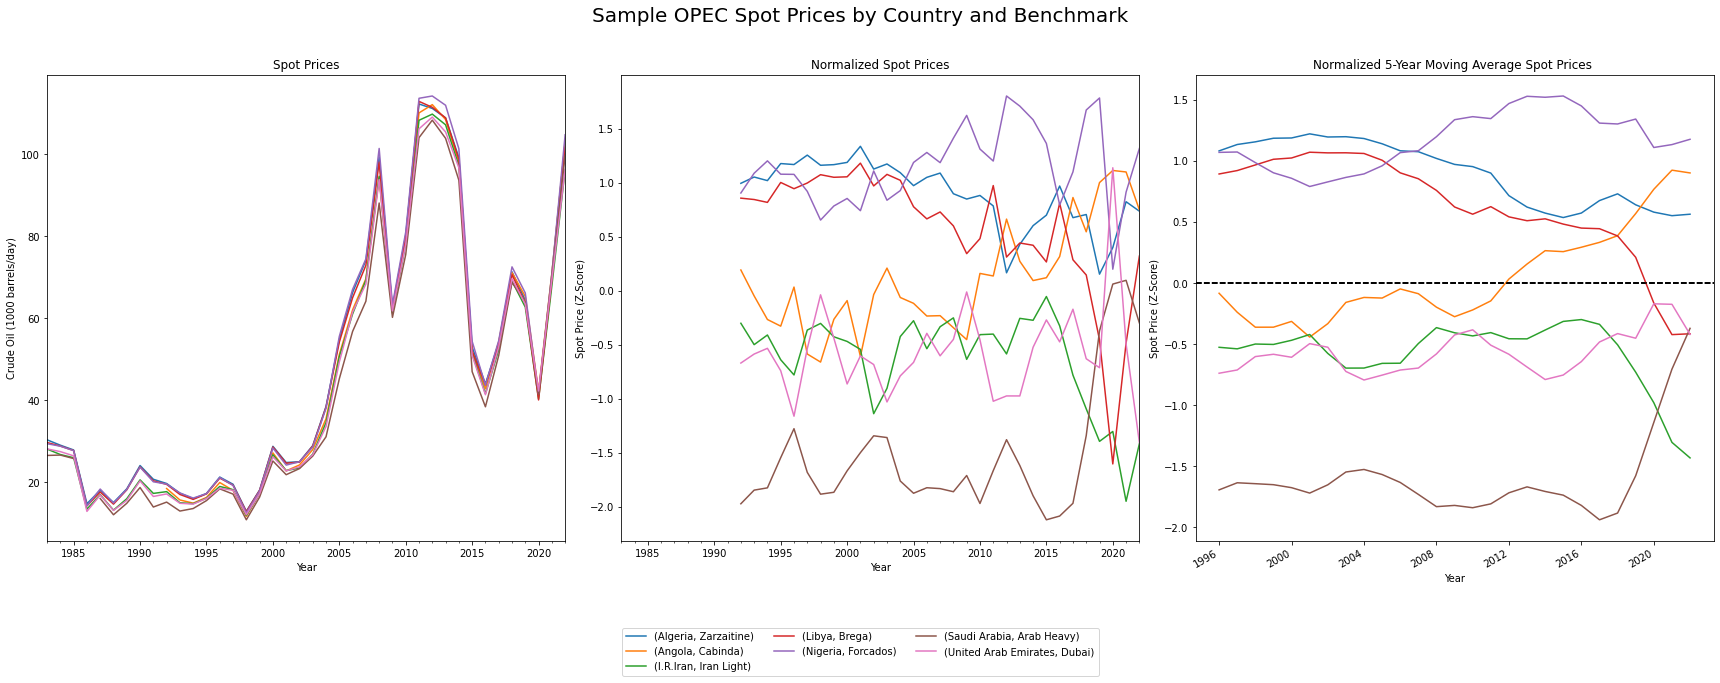

In [19]:
oil_spot_prices_countries = tuple(zip(*oil_spot_prices_df))[0]
opec_sample_countries = opec_countries[opec_countries.isin(oil_spot_prices_countries)]
line_plot_price(opec_sample_countries, "Sample OPEC Spot Prices by Country and Benchmark")

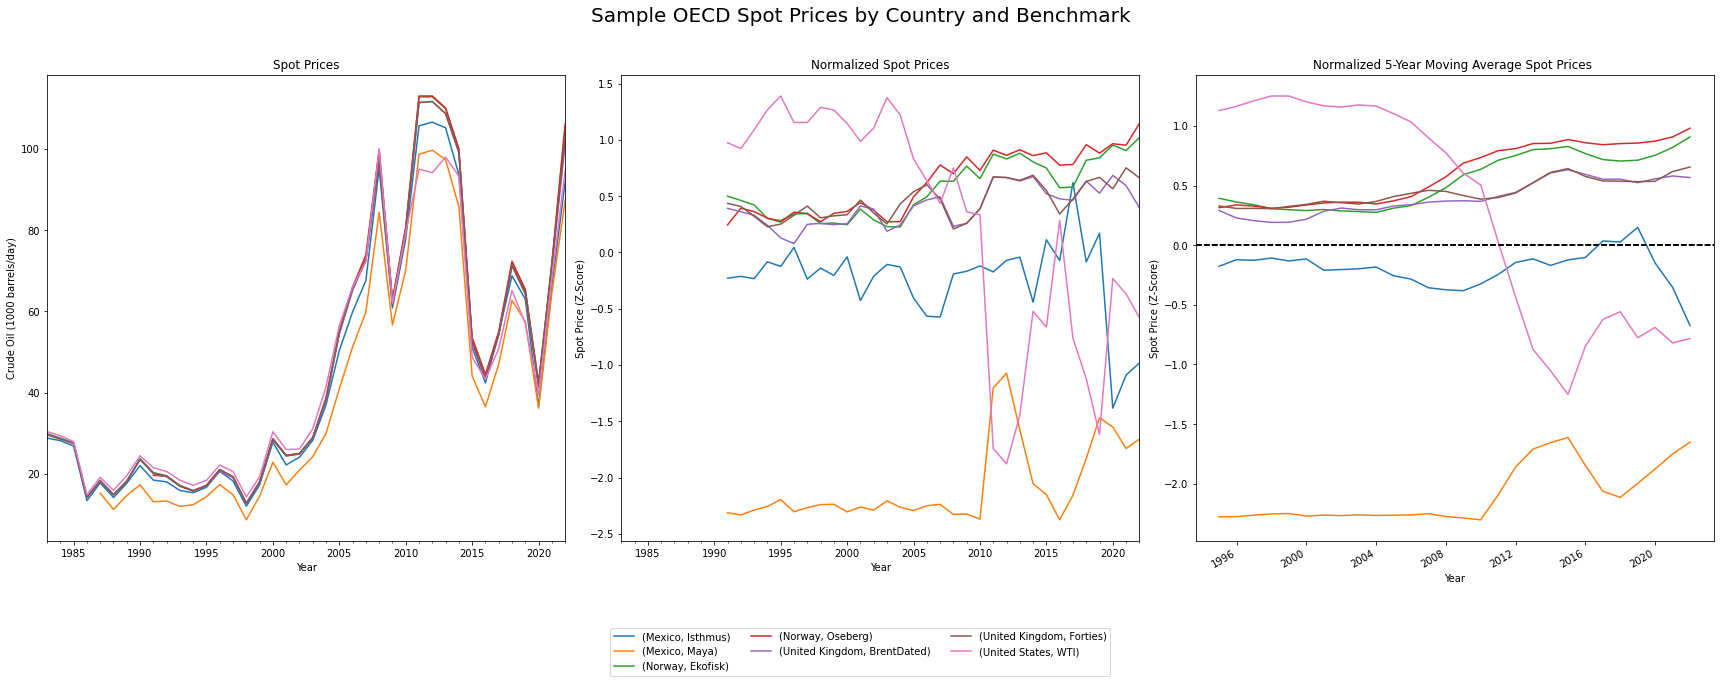

In [20]:
oecd_sample_countries = oecd_countries[oecd_countries.isin(oil_spot_prices_countries)]
line_plot_price(oecd_sample_countries, "Sample OECD Spot Prices by Country and Benchmark")

Observations from the spot price visualizations: 
- Saudi Heavy oil trades as a discount relative to all OPEC countries. 
- WIT oil became relatively cheaper then other OECD countries between 2003 and 2013. 
- The United Kingdoms Brent and Forties benchmarks trade at a tight spread from eachother. A factor of this is because Brent is a composite of the Forties benchmark. 

## OPEC Crude Oil Production Quotas

### Extract, Transform, and Load (ETL) Data

In [21]:
# Importing oil spot price dataset. 
oil_targets_df = pd.read_csv("data/summary/crude_oil_target.csv", index_col='Index')

def extract_numbers(s):
    numeric_values = re.findall(r'\d+', str(s))
    if numeric_values:
        return float(str().join(numeric_values))
    else:
        return np.NaN

oil_targets_df = oil_targets_df.applymap(extract_numbers)

# Transposing DataFrames to set years as index.  
oil_targets_df = oil_targets_df.transpose()

# Replacing incorrectly labeled countries. 
oil_targets_df = oil_targets_df.rename(columns={'IR Iran': 'I.R.Iran'})

# Removing sub exemptions from the quota values.  
opec_targets = ['OPEC', 'OPEC excl Iraq', 'OPEC excl Angola and Iraq',]
oil_targets_df[opec_targets] = oil_targets_df[opec_targets].apply(pd.to_numeric, errors='coerce')

# Converting date ranges to date time objects. 
oil_targets_df.index =  oil_targets_df.index.map(lambda x: x[:5])
oil_targets_df.index =  pd.to_datetime(oil_targets_df.index, format='%b%y')

# Dropping errors in the data. 
oil_targets_df.drop(['1998-04-01', '2006-11-01', '2007-02-01', '2008-11-01'], inplace=True)

# Display.
print(oil_targets_df.shape)
oil_targets_df.tail()

(75, 16)


Index,Algeria,Angola,Congo,Equatorial Guinea,Gabon,I.R.Iran,Iraq,Kuwait,Libya,Nigeria,Saudi Arabia,United Arab Emirates,Venezuela,OPEC,OPEC excl Iraq,OPEC excl Angola and Iraq
2022-07-01,1039.0,1502.0,320.0,125.0,183.0,NaN,4580.0,2768.0,NaN,1799.0,10833.0,3127.0,NaN,26276.0,NaN,NaN
2022-08-01,1055.0,1525.0,325.0,127.0,186.0,NaN,4651.0,2811.0,NaN,1826.0,11004.0,3179.0,NaN,26689.0,NaN,NaN
2022-09-01,1057.0,1529.0,325.0,127.0,187.0,NaN,4663.0,2818.0,NaN,1830.0,11030.0,3186.0,NaN,26752.0,NaN,NaN
2022-10-01,1055.0,1525.0,325.0,127.0,186.0,NaN,4651.0,2811.0,NaN,1826.0,11004.0,3179.0,NaN,26689.0,NaN,NaN
2022-11-01,1007.0,1455.0,310.0,121.0,177.0,NaN,4431.0,2676.0,NaN,1742.0,10478.0,3019.0,NaN,25416.0,NaN,NaN


In [22]:
# Converting monthly quota changed to be generalized by year.
date_range = pd.date_range(start='1983-01-01', end='2021-12-01', freq='MS')
temp_oil_targets_df = pd.DataFrame(columns=oil_targets_df.columns)
i = 0

for date in date_range:    
    row = oil_targets_df.iloc[i]
    next_row = oil_targets_df.iloc[i+1]
    
    if date < next_row.name:
        row.name = date
        temp_oil_targets_df = temp_oil_targets_df.append(row, ignore_index=False)
    else:
        next_row.name = date
        temp_oil_targets_df = temp_oil_targets_df.append(next_row, ignore_index=False)
        i += 1
    
def sum(series):
    if any(pd.isna(series)):
        return np.NaN
    else:
        return np.sum(series) / 12

temp_oil_targets_df = temp_oil_targets_df.groupby(pd.Grouper(freq='Y'))
temp_oil_targets_df = temp_oil_targets_df.agg(sum)
temp_oil_targets_df.index = pd.to_datetime(temp_oil_targets_df.index.year, format='%Y')
temp_oil_targets_df.head()


Index,Algeria,Angola,Congo,Equatorial Guinea,Gabon,I.R.Iran,Iraq,Kuwait,Libya,Nigeria,Saudi Arabia,United Arab Emirates,Venezuela,OPEC,OPEC excl Iraq,OPEC excl Angola and Iraq
1983-01-01,706.250000,NaN,NaN,NaN,150.000000,2100.000000,1200.0,987.5,1012.500000,1300.000000,5537.500000,1075.0,1631.250000,15700.000000,NaN,NaN
1984-01-01,714.666667,NaN,NaN,NaN,147.833333,2383.333333,1200.0,1025.0,1081.666667,1300.000000,4892.166667,1075.0,1655.000000,15474.666667,NaN,NaN
1985-01-01,663.000000,NaN,NaN,NaN,137.000000,2300.000000,1200.0,900.0,990.000000,1300.000000,4353.000000,950.0,1555.000000,14348.000000,NaN,NaN
1986-01-01,664.000000,NaN,NaN,NaN,140.833333,2302.833333,NaN,910.0,991.500000,1300.666667,4353.000000,950.0,1558.166667,NaN,NaN,NaN
1987-01-01,651.000000,NaN,NaN,NaN,155.500000,2312.000000,1503.0,972.0,972.000000,1269.500000,4238.000000,925.0,1533.000000,14531.000000,NaN,NaN


In [23]:
oil_targets_df.isna().sum()

Index
Algeria                       7
Angola                       48
Congo                        50
Equatorial Guinea            49
Gabon                        29
I.R.Iran                     33
Iraq                         31
Kuwait                        8
Libya                        34
Nigeria                       9
Saudi Arabia                  7
United Arab Emirates          7
Venezuela                    32
OPEC                         29
OPEC excl Iraq               51
OPEC excl Angola and Iraq    74
dtype: int64

### Exploratory Data Analysis (EDA)

In [24]:
# Plotting nations quotas and production. 
def plot_quotas(countries):
    fig, axs = plt.subplots(len(countries), 1, figsize=(12, 6*len(countries)))
    for i, country in enumerate(countries):
        axs[i].plot(oil_targets_df.index, oil_targets_df[country], color='blue', label='OPEC Quota')
        axs[i].plot(oil_production_df.index, oil_production_df[country], color='red', label='Production')
        axs[i].set_title(f"{country}'s Crude Oil OPEC Quota and Production Over Time")
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel('Crude Oil (1000 barrels/day)')
        axs[i].legend()

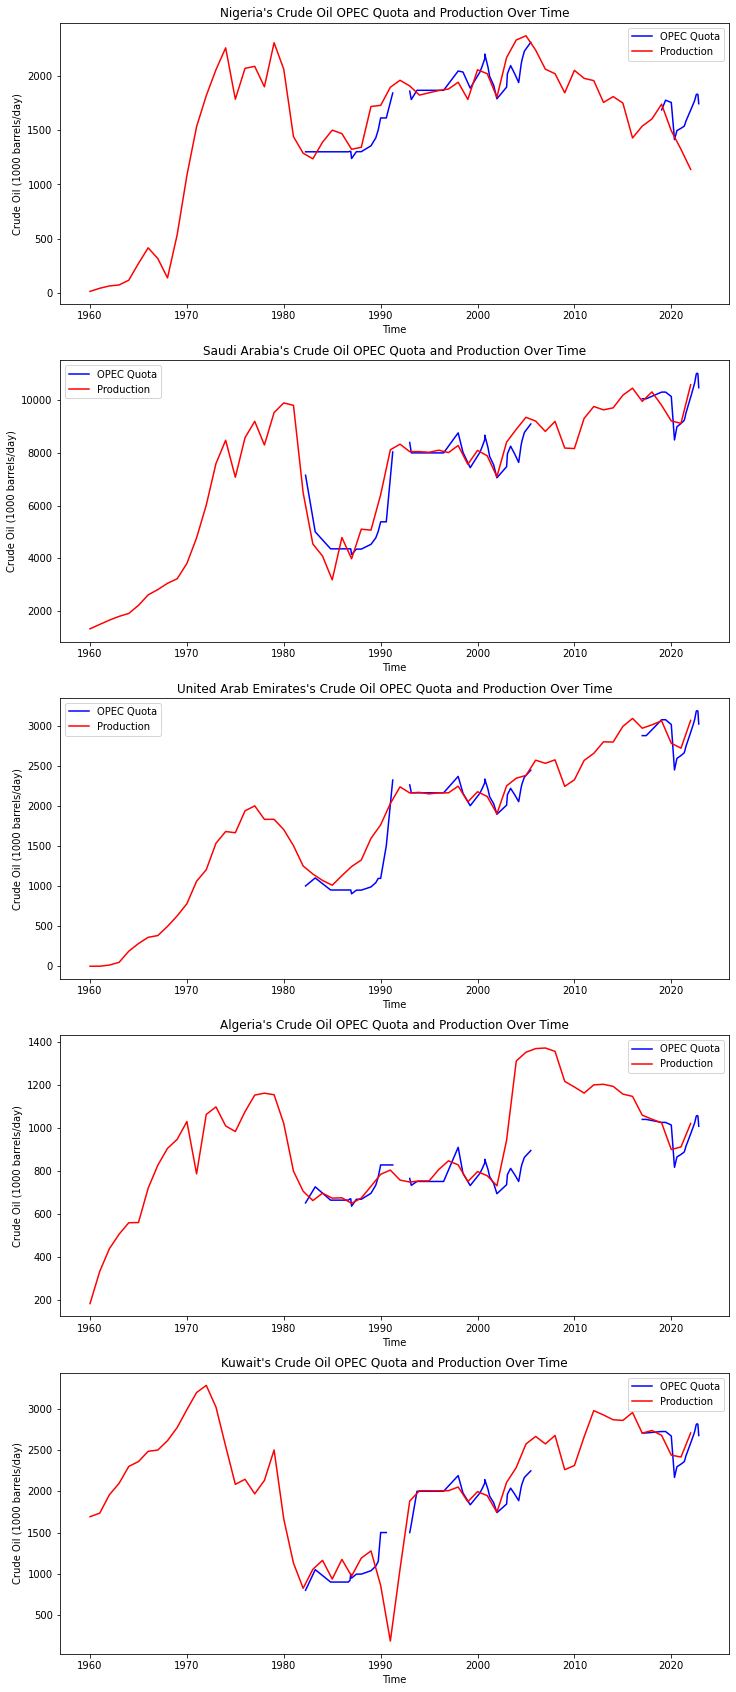

In [25]:
plot_quotas(['Nigeria', 'Saudi Arabia', 'United Arab Emirates', 'Algeria', 'Kuwait'])

## Model: Random Forest Regression of Spot Price Premium for ORB

When selecting this model, I noted these key observations about OPEC countries based on EDA: 
- All nations produce a **negative deficit** (positive surplus) of crude oil. 
- All nations do NOT set their own **production quotas**. 
- Some nations had a 100% **utilization rate**; this could be an error in my feature engineering. 
- Some OPEC nations (ex: Venezuela and Equatorial Guinea) have datasets missing over 50% of their data. 
- There is zero data on over 50% of OECD member nations.
- There is not enough data to model OPEC quota over production. 


In [26]:
# Combining all time interval data for a single OPEC nation. 
def merge_opec_datasets(country): 
    columns = [oil_production_df[country].rename('production'),
        oil_demand_df[country].rename('demand'),
        refinery_capacity_df[country].rename('capacity'),
        refinery_throughput_df[country].rename('throughput'),
        oil_spot_prices_df[country].iloc[:, 0].rename('price'),
        temp_oil_targets_df[country].rename('target')
        ]
    
    # Combining datasets. 
    df = pd.concat(columns, axis=1)
    df = df[(df.index >= '1983-01-01') & (df.index <= '2021-01-01')]
    df['overproduction'] = ((df['production'] - df['target']) / df['target']) * 100
    
    # Filling np.NaNs for ML. 
    df = df.dropna(subset=['overproduction'])
    imputer = SimpleImputer(strategy='median') 
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)        
    return df

# Combining all time interval data for a multiple OPEC nation. 
def merge_opec_countries(countries):
    dfs = list()
    
    for country in countries:
        try:
            df = merge_opec_datasets(country)   
            dfs.append(df)
            
        except KeyError as error: 
            print(f"{error} does not exist across all datasets.")    
            
    df = pd.concat(dfs, axis=0)
    return df

In [27]:
df = merge_opec_countries(opec_countries)
print(df.shape)
df.head()

'Equatorial Guinea' does not exist across all datasets.
'Gabon' does not exist across all datasets.
'Iraq' does not exist across all datasets.
'Kuwait' does not exist across all datasets.
'Congo' does not exist across all datasets.
'Venezuela' does not exist across all datasets.
(156, 7)


,production,demand,capacity,throughput,price,target,overproduction
0,660.900,150.0,471.2,378.0,30.398,706.250000,-6.421239
1,695.400,166.0,471.2,411.0,29.087,714.666667,-2.695896
2,672.377,165.0,471.2,408.0,27.925,663.000000,1.414329
3,673.883,171.0,471.2,434.0,14.832,664.000000,1.488404
4,648.225,175.0,471.2,412.0,18.095,651.000000,-0.426267


In [28]:
# Corr Matrix
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,production,demand,capacity,throughput,price,target,overproduction
production,1.000000,0.872084,0.904553,0.904615,0.099222,0.995081,-0.121675
demand,0.872084,1.000000,0.936868,0.935067,0.256443,0.879915,-0.177125
capacity,0.904553,0.936868,1.000000,0.979673,0.207169,0.906759,-0.164980
throughput,0.904615,0.935067,0.979673,1.000000,0.181643,0.903507,-0.140927
price,0.099222,0.256443,0.207169,0.181643,1.000000,0.107305,-0.049374
target,0.995081,0.879915,0.906759,0.903507,0.107305,1.000000,-0.195186
overproduction,-0.121675,-0.177125,-0.164980,-0.140927,-0.049374,-0.195186,1.000000


/var/folders/rq/9zvkr67d2mx07n6md37__xcr0000gn/T/ipykernel_26933/468630439.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  scatter_matrix(df, alpha=1.0, s=100, diagonal='kde', ax=axs)


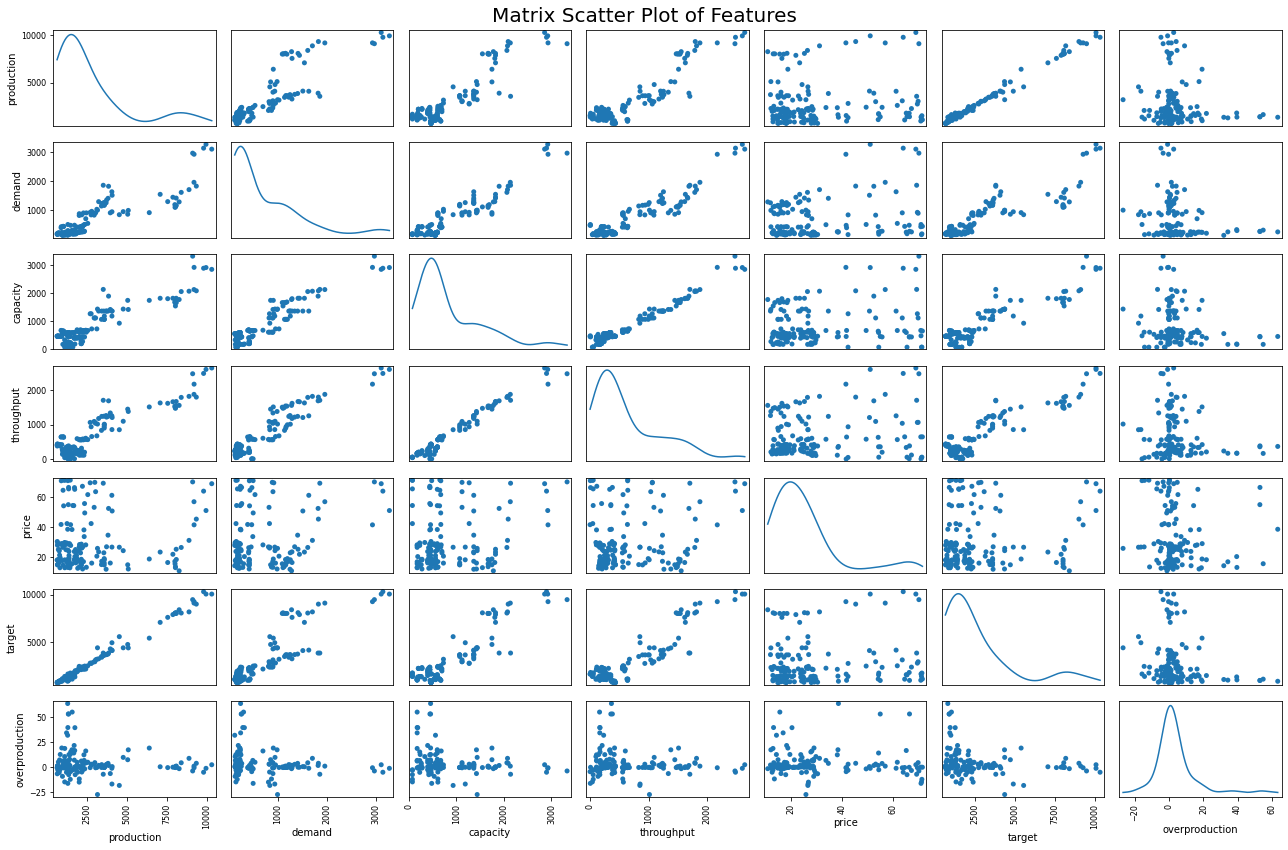

In [29]:
fig, axs = plt.subplots(figsize=(18, 12))
scatter_matrix(df, alpha=1.0, s=100, diagonal='kde', ax=axs)
fig.suptitle(f"Matrix Scatter Plot of Features", fontsize=20)
fig.tight_layout()

In [30]:
def build_model(X, y, model):
    print(f"Building {model} model:")
    
    # Separating train and test. 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    print("     X Train Shape:", X_train.shape)
    print("     X Test Shape:", X_test.shape)
    
    #Fit linear polynomial regression model. 
    model.fit(X_train, y_train)
    
    # Testing model accuracy. 
    y_pred = model.predict(X_test)
    mae_test = mean_absolute_error(y_test, y_pred)     
    
    print(f'     Test mean_absolute_error:', mae_test)
    print(f'     Test Mean Value:', y_test.mean())
    
    y_pred = model.predict(X_train)
    mae_train = mean_absolute_error(y_train, y_pred) 

    print(f'     Train mean_absolute_error:', mae_train)
    print(f'     Train Mean Value:', y_train.mean())

    return model

In [31]:
X, y = df.drop(columns=['production', 'target', 'overproduction']), df['overproduction']
model = build_model(X, y, RandomForestRegressor(random_state=42))

Building RandomForestRegressor(random_state=42) model:
     X Train Shape: (109, 4)
     X Test Shape: (47, 4)
     Test mean_absolute_error: 7.553281759241099
     Test Mean Value: 4.984905857577428
     Train mean_absolute_error: 2.492416118358394
     Train Mean Value: 3.073609292812633


In [32]:
importances = dict(zip(X.columns , model.feature_importances_))

print("Features importance in model:")
for feature, importance in importances.items():
    print(f"    {feature}: {importance:.2f}")

Features importance in model:
    demand: 0.37
    capacity: 0.16
    throughput: 0.18
    price: 0.30


In [33]:
# Converting python notebook to html.
!jupyter nbconvert --to html milestone_2.ipynb --output index

[NbConvertApp] Converting notebook milestone_2.ipynb to html
[NbConvertApp] Writing 1625971 bytes to index.html
